<a href="https://colab.research.google.com/github/sudip2k17/aidoctextextractor/blob/main/DocumentTextExtractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Preprocessing document before OCRing using OpenCV (Computer Vision)

Given a arbitrary photo containing a receipt, extract grand total

* Locate receipt contour on the photo
* Crop image to the receipt contour
* Apply perspective restoration

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage.filters import threshold_local
from PIL import Image

Scanning process

<ipython-input-3-81570f2fcf58>:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail((800,800), Image.ANTIALIAS)


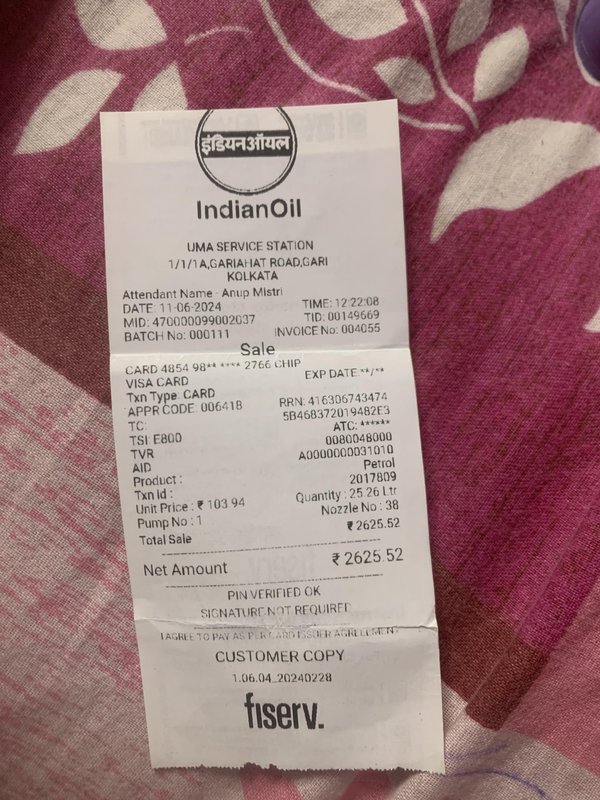

In [3]:
# Sample file out of the dataset
file_name = '/content/drive/MyDrive/dissertation/invoice/fuel-invoice-iocl.jpg'
img = Image.open(file_name)
img.thumbnail((800,800), Image.ANTIALIAS)
img

# Step 1: Receeipt Contour Detection

In order to find receipt contour, standart edge detection preprocessing is applied:

* Convert image to grayscale
* Aplly Gaussian filter 5x5 to get rid of noise
* Run Canny edge detector


Utility methods definitions

In [4]:
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

In [5]:
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [6]:
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

Downscale image for prominent contour finding in small image

In [7]:
image = cv2.imread(file_name)
# Downscale image as finding receipt contour is more efficient on a small image
resize_ratio = 500 / image.shape[0]
original = image.copy()
image = opencv_resize(image, resize_ratio)

Gray scale image conversion

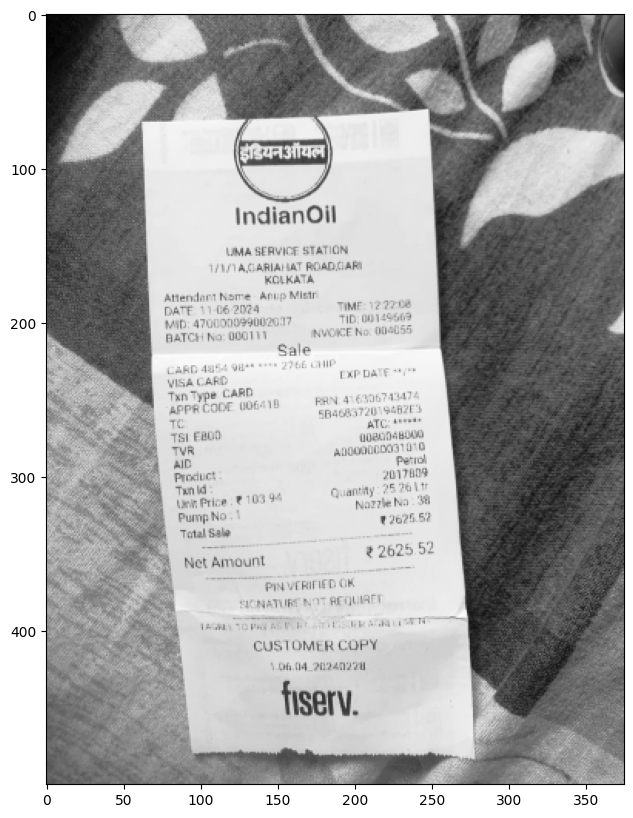

In [8]:
# Convert to grayscale for further processing
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plot_gray(gray)

Noise removal using Gaussian Blur Filter

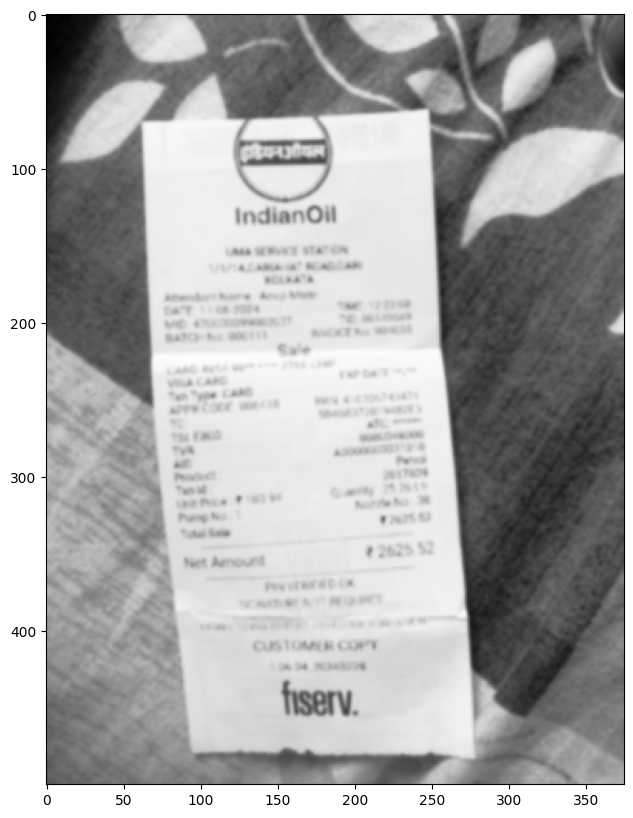

In [9]:
# Get rid of noise with Gaussian Blur filter
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plot_gray(blurred)

# White region detection in image

detect white region in image

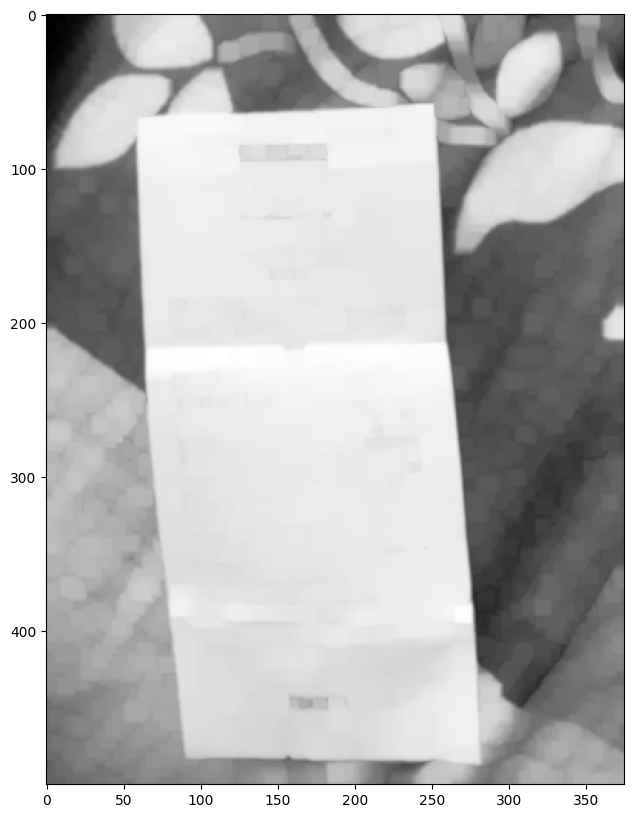

In [10]:
# Detect white regions
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
dilated = cv2.dilate(blurred, rectKernel)
plot_gray(dilated)

Apply Canny Edge Detection method for finding edges in image

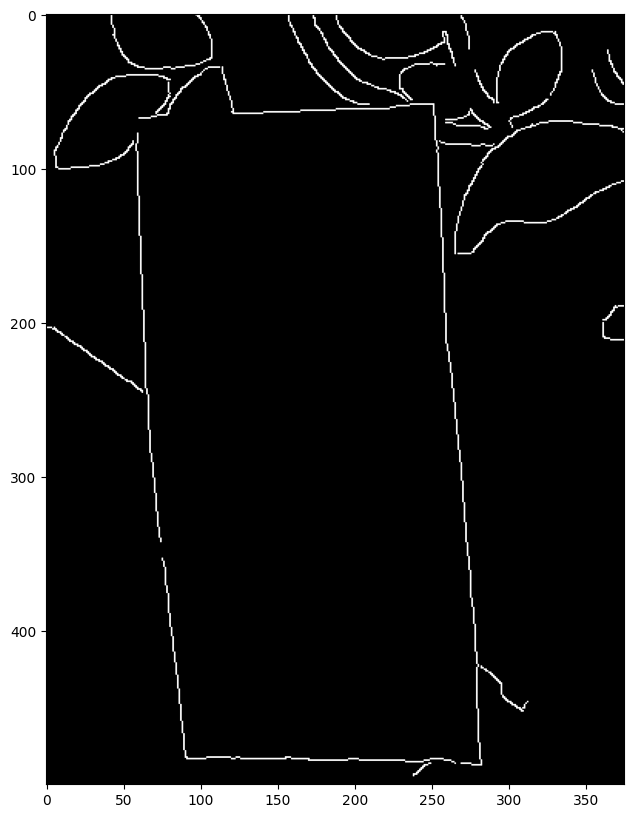

In [11]:
edged = cv2.Canny(dilated, 100, 200, apertureSize=3)
plot_gray(edged)

To find Contours in image, OpenCV version must be 3.0 or later version

In [12]:
cv2.__version__

'4.10.0'

Detect all contours in Canny edged image

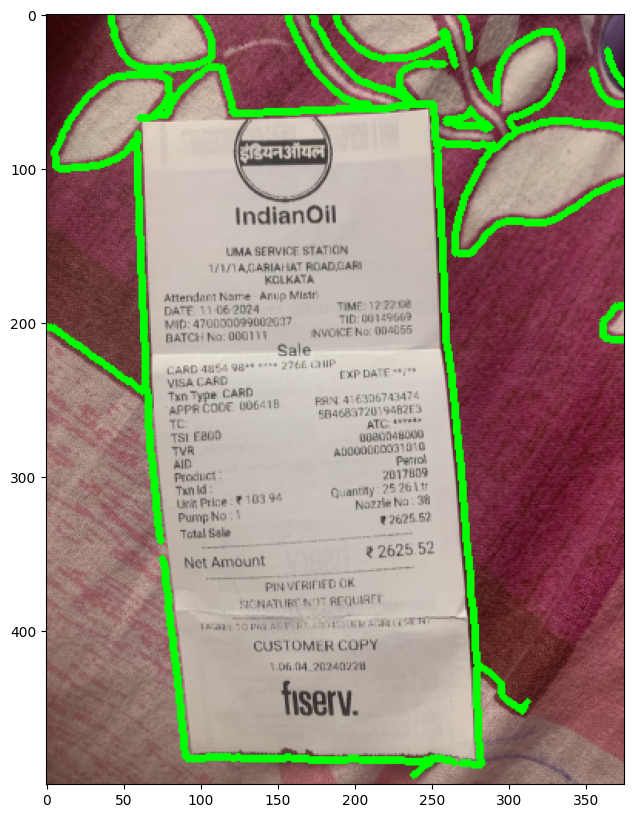

In [13]:
# Detect all contours in Canny-edged image
contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
plot_rgb(image_with_contours)

To find the contour of receipt two simple heuristics are used:
* receipt is the largest contour whithin image
* receipt is expected to be of a rectangular shape

The first heuristic is getting started by getting TOP largest contours.



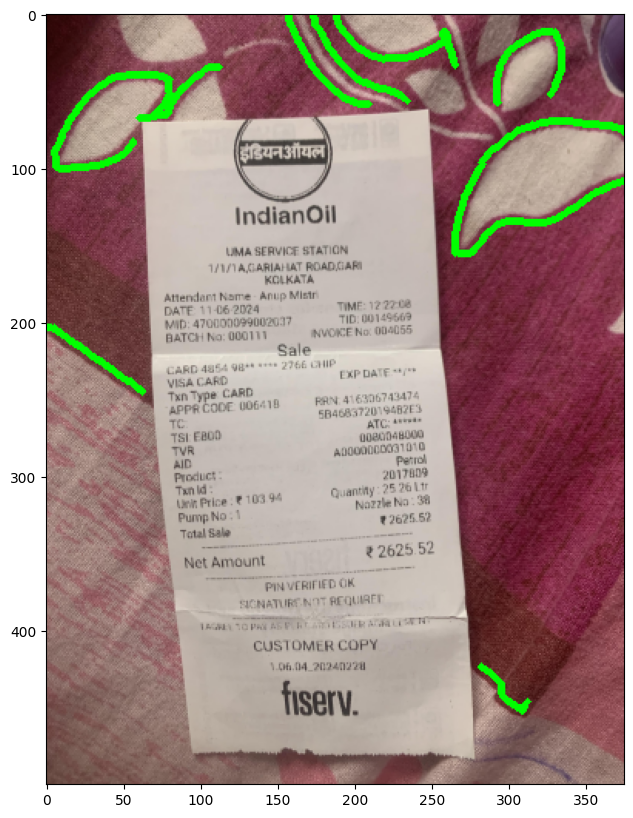

In [14]:
# Get 10 largest contours
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
plot_rgb(image_with_largest_contours)

The **approxPolyDP** for approximating more primitive contour shape consisting of as few points as possible. It takes perimeter as one of the arguments, so to calculate it with arcLength. Defining a helper method that does the approximation:

In [15]:
# approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

It signifies to find a rectangle by looking whether the number of approximated contour points is 4:

In [16]:
def get_receipt_contour(contours):
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        # if approximated contour has four points, it is assumed as it is receipt's rectangle
        if len(approx) == 4:
            return approx

In [17]:
get_receipt_contour(largest_contours)

array([[[374,  74]],

       [[299,  79]],

       [[265, 155]],

       [[300,  79]]], dtype=int32)

It is also important to get down to just four contour points, as its needed them for perspective restoration

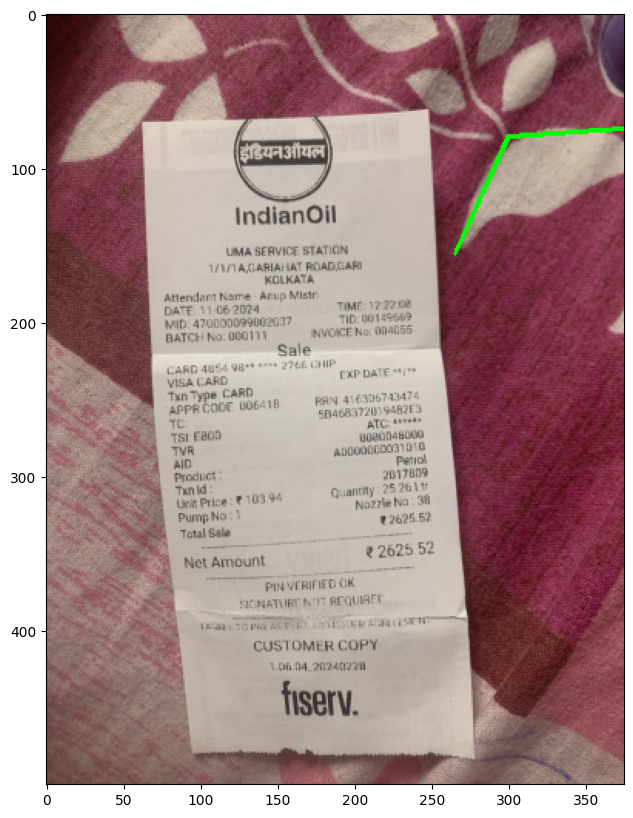

In [18]:
receipt_contour = get_receipt_contour(largest_contours)
image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0, 255, 0), 2)
plot_rgb(image_with_receipt_contour)

## Step 2: Cropping and perspective restoration

Using **cv2.warpPerspective** to restore perspective of the receipt. Some preparations needed as:

* convert contour into a rectangle-like coordinate array consisting of clockwise ordered points: top-left, top-right, bottom-right, bottom-left

* use rectangle points to calculate destination points of the "scanned" view

* feed destination points into cv2.getPerspectiveTransform to calculate transformation matrix

* and finally use cv2.warpPerspective to restore the perspective

Following helper methods are required for cropping

In [19]:
def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio

In [20]:
def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

Using helper methods defined above to get a perspective version of the receipt

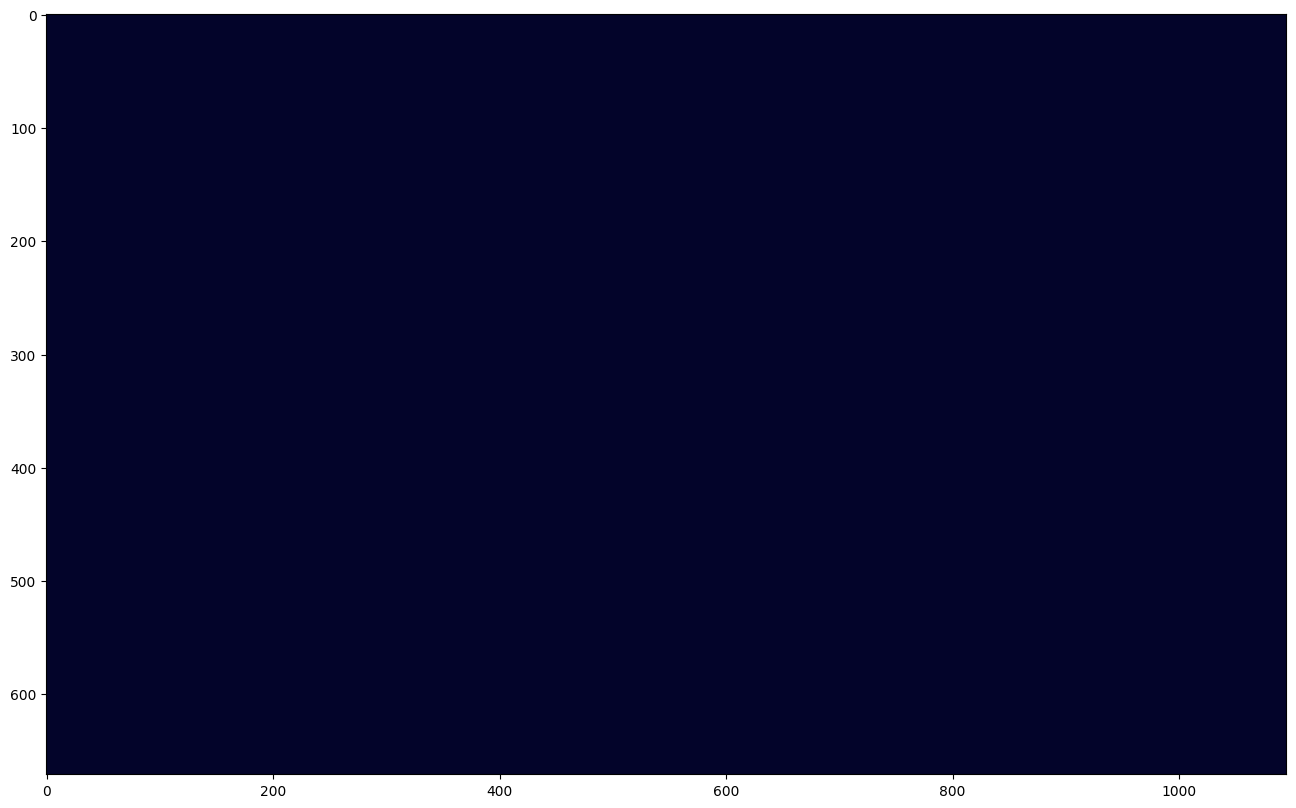

In [21]:
scanned = wrap_perspective(original.copy(), contour_to_rect(receipt_contour))
plt.figure(figsize=(16,10))
plt.imshow(scanned)

Obtain black and white scanner effect with the color transformation

In [22]:
def bw_scanner(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 21, offset = 5, method = "gaussian")
    return (gray > T).astype("uint8") * 255

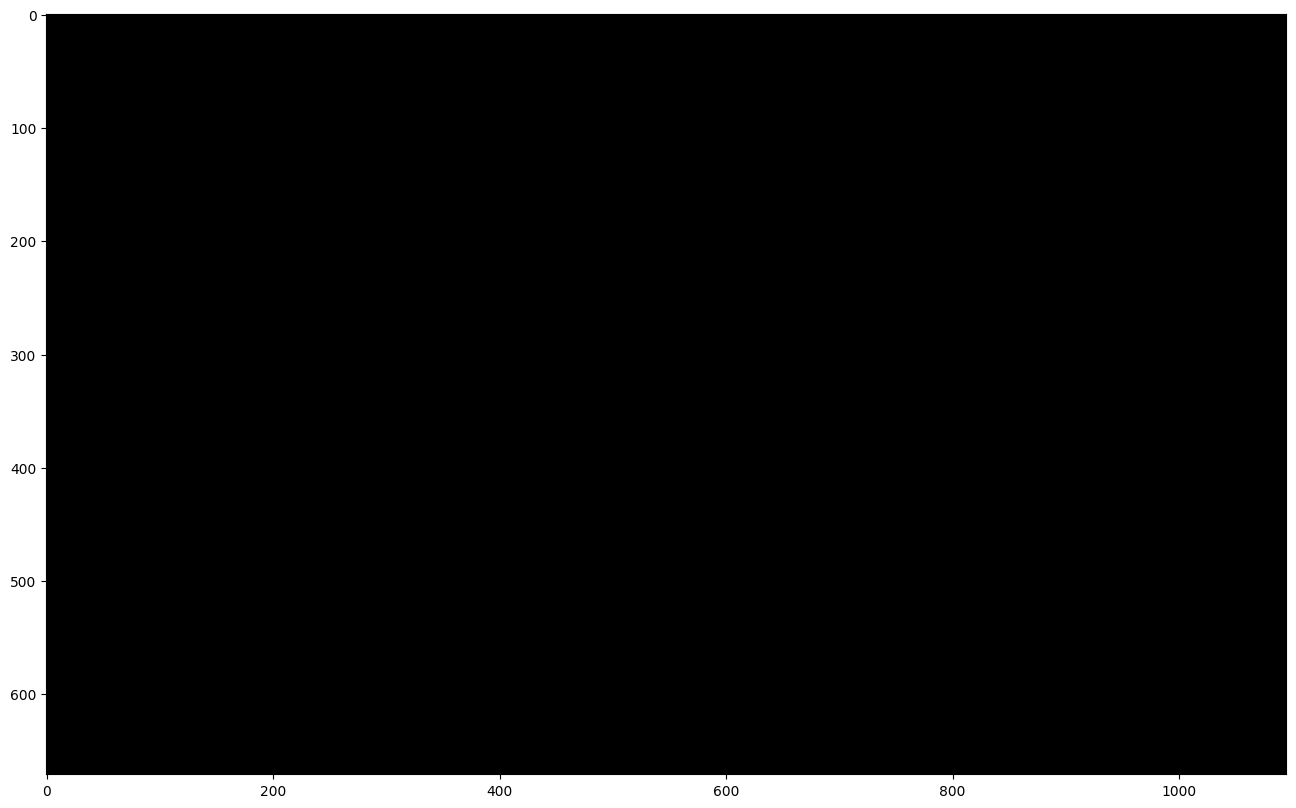

In [23]:
result = bw_scanner(scanned)
plot_gray(result)

In [24]:
output = Image.fromarray(result)
output.save('result.png')